##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024
### TP1 - Recherche de documents avec une métrique de similarité


## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- Lucie Legarez 2413157 (1/3 de contribution, Traitement et prétraitement des données, Graphique BM25 / TF_IDF)
- Gervais Presley Koyaweda 2305686 (1/3 de contribution, Traitement des données, Creation des différentes fonctions de prétraitement, Mise en place du BM25)
- Ibrahima Ba 1943223 (1/3 de contribution, Traitement et Prétraitement des données, Optimisation des scripts, Observations BM25 et Commentaires)

##### Le TP s'est fait de façon indépendante avec comme objectif de comparer nos différents résultats et de choisir les scipts les  plus simples et rapide à chaque étape. Tous les membres de l'équipe ont travaillé sur chacune des 3 parties et les efforts fournis ont été équitables. 

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## Mise en place

### Objectif du TP

La recherche d'information est le processus d'accès aux données, généralement des documents ou d'autres données non structurées, à partir d'une requête. Dans ce TP, vous aurez en entrée une requête textuelle sous forme d'affirmation. Il faudra retrouver dans un corpus de littérature scientifique les documents pertinents qui justifient ou infirment la véracité de cette affirmation. Vous utiliserez des modèles vectoriels et des métriques de similarité pour cette tâche.

### Jeux de données

Dans ce TP, vous utiliserez le jeu de données dans le répertoire _data_. Il s'agit d'un ensemble de données comprenant 809 affirmations rédigées par des experts et 5183 documents de références pour ces affirmations. Ces documents contiennent des phrases qui confirment ou infirment (contredisent) les affirmations. L'objectif est donc de trouver un document pertinent, c'est-à-dire contenant la ou les phrases qui permettent d'évaluer une affirmation donnée en entrée en utilisant une similarité sémantique. 

Le jeu de données comprend :

1. Un corpus (_corpus.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'doc_id' : permet d'identifier le document en entrée
    - 'title' : donne le titre du document
    - 'abstract': est le résumé du document
    - 'structured': indique si le document est structuré ou pas

2. Un ensemble d'affirmations (_claims.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'id' : identifie l'affirmation.
    - 'claim' : est l'affirmation en tant que telle.
    - 'evidence' : précise quelles phrases du document sont pertinentes pour l'affirmation. Chaque phrase est accompagnée d'une étiquette de véracité (confirm/contradict) pour indiquer si la phrase confirme ou contredit l'affirmation.  
    - 'cited_doc_ids' : indique les identifiants des documents cités.



Dans _claims.jsonl_, seuls les identifiants des documents sont renseignés. Pour avoir les détails d'un document tel que le titre ("title") et le résumé ("abstract"), il faudra consulter le fichier _corpus.jsonl_. 

Voici un exemple :

- **Affirmation (claim)** : Consumption of whole fruits increases the risk of type 2 diabetes.
- **Cited document(s) ID(s)** : 1974176
- **Evidence (sentence in the document containing the proof)** : [{'sentences': [11], 'label': 'CONTRADICT'}]

  Ici [11] constitue le numéro de la phrase qui contredit l'affirmation.

- **Cited document(s) title(s)** : Fruit consumption and risk of type 2 diabetes: results from three prospective longitudinal cohort studies
- **Cited document(s) abstract(s) (list of sentences)** : 
    - [0] 'OBJECTIVE To determine whether individual fruits are differentially associated with risk of type 2 diabetes.\n'
    - [1] 'DESIGN Prospective longitudinal cohort study.'
    - ...
    - [10] 'CONCLUSION Our findings suggest the presence of heterogeneity in the associations between individual fruit consumption and risk of type 2 diabetes.'
    - [11] 'Greater consumption of specific whole fruits, particularly blueberries, grapes, and apples, is significantly associated with a lower risk of type 2 diabetes, whereas greater consumption of fruit juice is associated with a higher risk.'

Le champ "evidence" indique la phrase au niveau du résumé du document qui confirme ou infirme l'affirmation, d'où le numéro de la phrase et le label qui y sont renseignés. Dans le cas particulier de l'exemple ci-dessus, on voit bien que la onzième phrase du résumé du document est la plus pertinente pour l'affirmation et qu'elle la contredit, ce qui explique le label "CONTRADICT" dans "evidence". Cependant, dans le cadre de ce TP, on ne s'intéresse qu'à la présence de cette phrase pertinente dans le document, donc on ne considérera pas cette colonne "evidence" dans la suite du TP.

### Librairies permises
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- PowerLaw
- Matplotlib
- TQDM
- BM25
- Pour toute autre librairie, demandez à votre chargé de laboratoire

## Étapes du TP
A partir du notebook _INF8460_A24_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

In [14]:
# Lien vers les fichiers à utiliser
# Ne pas modifier

PATH = 'data/ai2_data/'

In [10]:
#!pip install rank_bm25 
#!pip install powerlaw
#!pip install tabulate

In [15]:
# Import des librairies

import numpy as np
import pandas as pd
import powerlaw
import json
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict
%config InlineBackend.figure_format = 'retina'

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from string import punctuation
from tabulate import tabulate

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi

In [16]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gpres\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gpres\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Traitement des données (15 points)
Vous allez effectuer une analyse afin d'avoir une idée claire des données que vous aurez à manipuler.

#### 1.1 Chargement des données (2 points)

##### 1.1.1 Chargement et affichage des données (1 point)

Chargez les données '_claims.jsonl_' et '_corpus.jsonl_' puis affichez-les dans des dataframes en utilisant panda.

In [17]:
# Lecture des donnees

df_claims = pd.read_json(PATH + "claims.jsonl", lines=True)
df_corpus = pd.read_json(PATH + "corpus.jsonl", lines=True)

In [18]:
# Affichage de df_claims

df_claims

,id,claim,evidence,cited_doc_ids
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818]
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012]
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787]
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775]
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107]
...,...,...,...,...
804,1403,siRNA knockdown of A20 accelerates tumor progr...,"{'33370': [{'sentences': [6], 'label': 'CONTRA...","[33370, 38355793]"
805,1404,siRNA knockdown of A20 slows tumor progression...,"{'33370': [{'sentences': [6], 'label': 'SUPPOR...","[33370, 38355793]"
806,1405,taa1 tar1 tar2 triple mutants in Arabidopsis d...,{},[10504681]
807,1406,β-sheet opening occurs during pleurotolysin po...,"{'2617858': [{'sentences': [4], 'label': 'SUPP...",[2617858]


In [19]:
# Affichage de df_corpus

df_corpus

,doc_id,title,abstract,structured
0,4983,Microstructural development of human newborn c...,[Alterations of the architecture of cerebral w...,False
1,5836,Induction of myelodysplasia by myeloid-derived...,[Myelodysplastic syndromes (MDS) are age-depen...,False
2,7912,"BC1 RNA, the transcript from a master gene for...",[ID elements are short interspersed elements (...,False
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,[DNA methylation plays an important role in bi...,False
4,19238,The human myelin basic protein gene is include...,[Two human Golli (for gene expressed in the ol...,False
...,...,...,...,...
5178,195689316,Body-mass index and cause-specific mortality i...,[BACKGROUND The main associations of body-mass...,True
5179,195689757,Targeting metabolic remodeling in glioblastoma...,[A key aberrant biological difference between ...,False
5180,196664003,Signaling architectures that transmit unidirec...,[A signaling pathway transmits information fro...,False
5181,198133135,"Association between pre-diabetes, type 2 diabe...",[AIMS Trabecular bone score (TBS) is a surroga...,True


##### 1.1.2 Statistique sur les évidences (1 point)

Calculez les pourcentages d'apparition de chaque label des évidences dans "_df_claims_" (CONTRADICT ou SUPPORT). Pour rappel les évidences sont les extraits pertinents des résumés qui supportent ou contredisent les affirmations. 

In [20]:
# Fonction d'extraction des labels de chaque evidence

def extract_label(evidence):    
    return [evidence.get('label') for doc_id, evidences in evidence.items() for evidence in evidences]

# Application de la fonction à notre df pour extraire les labels dans une nouvelle colonne
all_labels = df_claims['evidence'].apply(lambda x: extract_label(x)).explode()

# On compte chaque label
label_counts = all_labels.value_counts()

# Calcul du pourcentage de chaque label
label_percentages = (label_counts / label_counts.sum()) * 100

# Arrondi du pourcentage à 2 chiffres après la virgule
label_percentages = label_percentages.round(2)

# Ajout du symbole de pourcentage
label_percentages = label_percentages.astype(str) + '%'

label_percentages

evidence
SUPPORT       64.37%
CONTRADICT    35.63%
Name: count, dtype: object

> Réponse attendue:
> 
> CONTRADICT: 35.63%
> 
> SUPPORT: 64.37%

#### 1.2 Analyse statistique des données (7 points)

Nous allons faire une suite de transformations sur les données pour les rendre plus faciles à manipuler.

##### 1.2.1 Implémentation de la fonction "_list_to_string_" 

Nous mettons à votre disposition la fonction "_list_to_string_" qui transforme une liste de phrases en un texte en les concaténant et enlèvant tous les caractères de nouvelle ligne (`\n`) pour s'assurer que nous avons un texte complet. 

In [21]:
# On transforme la liste de phrases en un texte

def list_to_string(x):
    if isinstance(x, list):
        return ' '.join(str(i).replace("\n","").replace("  "," ") for i in x)
    return str(x)

##### 1.2.2 Utilisation de la fonction "_list_to_string_" 

Appliquons cette fonction "_list_to_string_" aux colonnes "_title_" et "abstract" du dataframe "_df_corpus_".

In [22]:
# On applique la fonction aux colonnes "title" et "abstract"

df_corpus['title']    = df_corpus['title'].apply(list_to_string)
df_corpus['abstract'] = df_corpus['abstract'].apply(list_to_string)

##### 1.2.3 Ajout de la colonne "_text_" dans "df_corpus"


Ajoutons maintenant une colonne "_text_" qui est la concaténation du titre ("_title_") et du résumé ("_abstract_") au niveau du dataframe "df_corpus".

In [23]:
# On concatene les textes dans "title" et "abstract"

df_corpus['text'] = df_corpus['title'] + " " + df_corpus['abstract']

##### 1.2.4 Ajout de colonnes dans "_df_claims_" (1 point)

Ajoutez les colonnes "_claim_length_" et "_num_cited_doc_" qui donnent, pour chaque affirmation, le nombre de mots dans la colonne "_claim_" et le nombre de documents cités au niveau de la colonne "_cited_doc_ids_" pour le dataframe "_df_claims_". Vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [24]:
# Fonction pour compter le nombre de mots dans une chaîne de caractères
def count_words(text):
    return len(str(text).split())

# Fonction pour compter le nombre d'éléments dans une liste
def count_elements_list(liste):
    if isinstance(liste, list):
        return len(liste)
    else:
        return 0

# Ajout de la colonne "claim_length" qui compte le nombre de mots dans la colonne "claim"
df_claims["claim_length"] = df_claims["claim"].apply(count_words)

# Ajout de la colonne "num_cited_doc" qui compte le nombre de documents cités dans "cited_doc_ids"
df_claims["num_cited_doc"] = df_claims["cited_doc_ids"].apply(count_elements_list)

In [25]:
df_claims

,id,claim,evidence,cited_doc_ids,claim_length,num_cited_doc
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818],5,1
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012],10,1
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787],12,1
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775],16,1
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107],13,1
...,...,...,...,...,...,...
804,1403,siRNA knockdown of A20 accelerates tumor progr...,"{'33370': [{'sentences': [6], 'label': 'CONTRA...","[33370, 38355793]",14,2
805,1404,siRNA knockdown of A20 slows tumor progression...,"{'33370': [{'sentences': [6], 'label': 'SUPPOR...","[33370, 38355793]",14,2
806,1405,taa1 tar1 tar2 triple mutants in Arabidopsis d...,{},[10504681],14,1
807,1406,β-sheet opening occurs during pleurotolysin po...,"{'2617858': [{'sentences': [4], 'label': 'SUPP...",[2617858],7,1


##### 1.2.5 Ajout des colonnes de mesures de longeurs de textes (documents) (1 point)

Ajoutez les colonnes "_title_length_", "_abstract_length_" et "_text_length_" qui donnent le nombre de mots dans les colonnes "_title_", "_abstract_" et "_text_" du dataframe "_df_corpus_". Pour le reste du TP, nous définirons la longueur du "_title_", "_abstract_" et du "_text_" comme étant le nombre de mots dans les chaînes de caractères respectives. Encore une fois, vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [26]:
# Ajout de la colonne title_length qui compte le nombre de mots dans la colonne title
df_corpus["title_length"] = df_corpus["title"].apply(count_words)

# Ajout de la colonne abstract_length qui compte le nombre de mots dans la colonne abstract
df_corpus["abstract_length"] = df_corpus["abstract"].apply(count_words)

# Ajout de la colonne text_length qui compte le nombre de mots dans la colonne text
df_corpus["text_length"] = df_corpus["text"].apply(count_words)

In [27]:
df_corpus

,doc_id,title,abstract,structured,text,title_length,abstract_length,text_length
0,4983,Microstructural development of human newborn c...,Alterations of the architecture of cerebral wh...,False,Microstructural development of human newborn c...,17,278,295
1,5836,Induction of myelodysplasia by myeloid-derived...,Myelodysplastic syndromes (MDS) are age-depend...,False,Induction of myelodysplasia by myeloid-derived...,7,201,208
2,7912,"BC1 RNA, the transcript from a master gene for...",ID elements are short interspersed elements (S...,False,"BC1 RNA, the transcript from a master gene for...",20,180,200
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,DNA methylation plays an important role in bio...,False,The DNA Methylome of Human Peripheral Blood Mo...,9,238,247
4,19238,The human myelin basic protein gene is include...,Two human Golli (for gene expressed in the oli...,False,The human myelin basic protein gene is include...,21,241,262
...,...,...,...,...,...,...,...,...
5178,195689316,Body-mass index and cause-specific mortality i...,BACKGROUND The main associations of body-mass ...,True,Body-mass index and cause-specific mortality i...,15,413,428
5179,195689757,Targeting metabolic remodeling in glioblastoma...,A key aberrant biological difference between t...,False,Targeting metabolic remodeling in glioblastoma...,6,159,165
5180,196664003,Signaling architectures that transmit unidirec...,A signaling pathway transmits information from...,False,Signaling architectures that transmit unidirec...,8,246,254
5181,198133135,"Association between pre-diabetes, type 2 diabe...",AIMS Trabecular bone score (TBS) is a surrogat...,True,"Association between pre-diabetes, type 2 diabe...",14,233,247


##### 1.2.6 Analyse statistique (1.5 point)

Faites l'analyse statistique des données en affichant le "_min_", le "_max_" et la "_moyenne_" pour les deux colonnes "_claim_length_" et "_num_cited_doc_" que vous venez de créer.

In [28]:
# Analyse statistique sur les deux colonnes "claim_length" et "num_cited_doc"
stats = df_claims[['claim_length', 'num_cited_doc']].agg(['min', 'max', 'mean'])

print(stats)

      claim_length  num_cited_doc
min       3.000000        1.00000
max      39.000000        5.00000
mean     12.332509        1.13597


In [29]:
list_var = ["claim_length", "num_cited_doc"]

for var in list_var:
    
    minimum = df_claims[var].min()
    maximum = df_claims[var].max()
    moyenne = df_claims[var].mean()
    
    # Affichage des mesures de dispersion pour chaque variable
    print(f"Tendances centrales de {var}\n Min: {minimum}\n Max: {maximum}\n Moyenne: {moyenne:.2f}\n")

Tendances centrales de claim_length
 Min: 3
 Max: 39
 Moyenne: 12.33

Tendances centrales de num_cited_doc
 Min: 1
 Max: 5
 Moyenne: 1.14



##### 1.2.7 Histogrammes (2 points)

En considérant le dataframe du corpus de résumés ("_df_corpus_"), affichez dans 3 histogrammes les distributions suivantes:

- Fréquence des titres ('_title_') en fonction de leur longueur
- Fréquence des résumés ('_abstract_') en fonction de leur longueur
- Fréquence des textes ('_text_') en fonction de leur longueur

Utilisez la valeur de 30 pour le paramètre "_bins_"

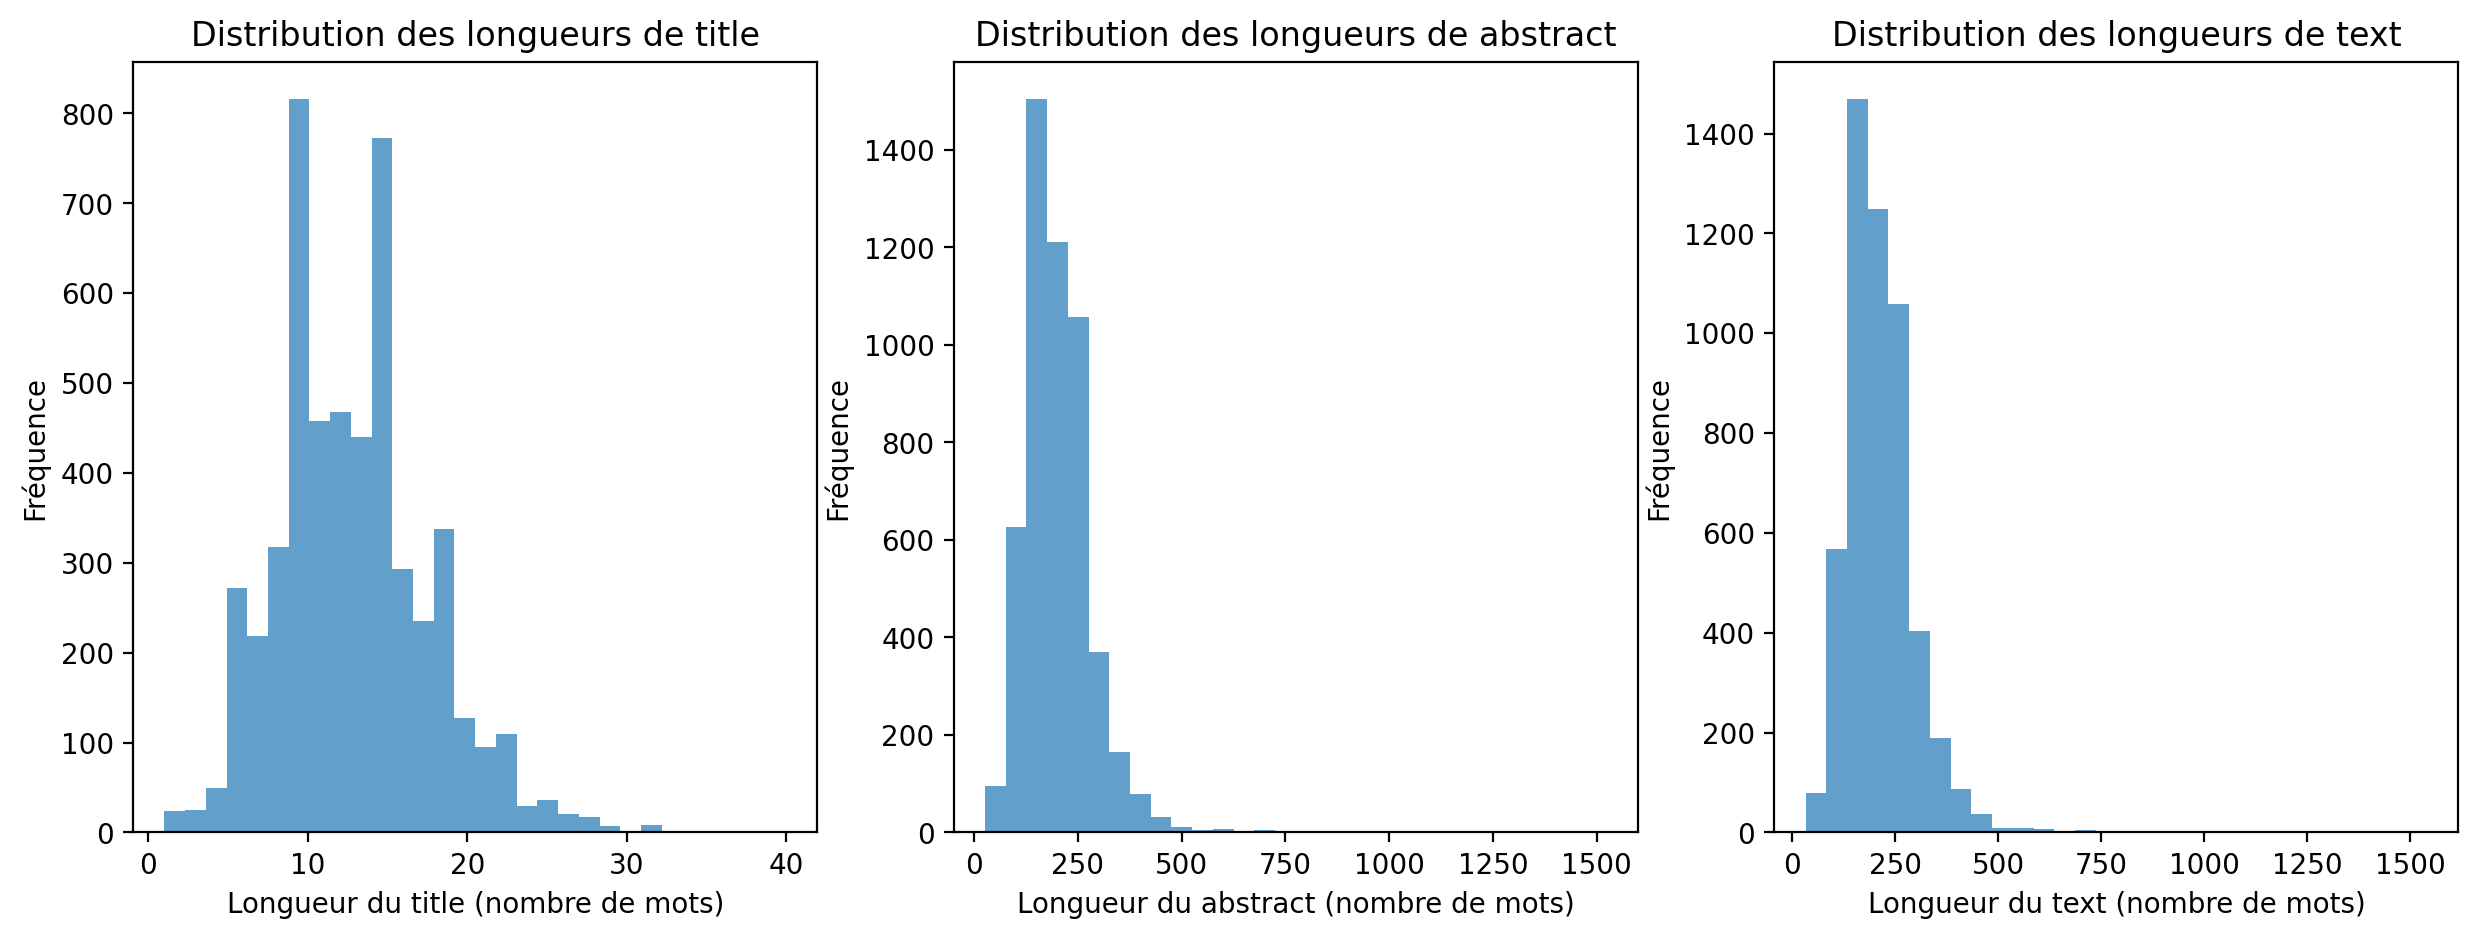

In [30]:
# Extraction des colonnes à etudier
list_var_graph = ["title", "abstract", "text"]

# Construction des histogrames pour chaque colonne
plt.figure(figsize=(15, 5))

for i, var in enumerate(list_var_graph, 1):
    plt.subplot(1, 3, i)
    plt.hist(df_corpus[f"{var}_length"], bins=30, alpha=0.7)
    plt.title(f"Distribution des longueurs de {var}")
    plt.xlabel(f"Longueur du {var} (nombre de mots)")
    plt.ylabel("Fréquence")

##### 1.2.8 Quelles remarques faites-vous sur les affirmations (claims) et les documents ? (1.5 points) 

En observant les maximums, les minimums et les moyennes, que remarquez-vous à propos des affirmations ('_claims_') ? À l'aide des graphiques générés, comparez également les documents.

<font color='red'>

#### En analysant les statistiques, nous observons les points suivants :
- Certaines affirmations sont très courtes, tandis que d'autres sont relativement longues.
- En moyenne, une seule source est citée pour justifier une affirmation, ce qui semble limité.

En examinant les histogrammes, nous constatons que :
- La colonne "title" n'apporte pas beaucoup d'informations supplémentaires par rapport à la colonne "text", 
   car les distributions de "text" et "abstract" sont presque identiques.

</font>

#### 1.3 Pré-traitement (6 points)
Les affirmations et résumés de texte de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de document (pouvant être "_title_", "_abstract_" ou la fusion des deux représentée par "_text_") qui justifie/contredit une affirmation. Vous devez donc implémenter une étape de pré-traitement des données.

##### 1.3.1 Implémentation de la fonction "_tokenize_sentence_" (1 point)

Implémentez la fonction "_tokenize_sentence_" pour la segmentation d'une phrase en une liste de jetons. Utilisez la librarie `nltk`.

In [31]:
# Fonction de segmentation d'une phrase en liste de jetons
def tokenize_sentence(sentence):
    
    tokenized_sentence = word_tokenize(sentence)
    return tokenized_sentence

##### 1.3.2 Implémentation de la fonction "_tokenize_text_" (1 point)
Implémentez la fonction "_tokenize_text_" qui utilise "_tokenize_sentence_" pour faire la segmentation d'un texte (liste de phrases).

In [32]:
# Fonction utilisant "tokenize_sentence" pour segmenter un texte
from nltk.tokenize import sent_tokenize

def tokenize_text(text):
    
    sentences = sent_tokenize(text)
    tokenized_text = [tokenize_sentence(sentence) for sentence in sentences]
    return tokenized_text

##### 1.3.3 Implémentation de la fonction "_stem_tokens_" (1 point)

Implémentez la fonction "_stem_tokens_" qui prend une liste de jetons (tokens) en entrée et retourne une liste contenant leur forme racinisée (stems) en utilisant l'algorithme de racinisation PorterStemmer de la bibliothèque nltk.

In [33]:
# Fonction de racinisation
def stem_tokens(tokenized_text):
    
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokenized_text]  # Stemming des tokens
    return stemmed_tokens

##### 1.3.4 Pré-traitement (2 points)

En utilisant vos précédentes fonctions, faites maintenant le pré-traitement des champs "_text_", "_title_" et "_abstract_" du dataframe "_df_corpus_" et "_claim_" du dataframe "_df_claims_" en suivant les étapes suivantes:
- conversion en minuscules
- segmentation (tokenization) des passages
- suppression des stop-words et ponctuation
- racinisation (stemming) des jetons

Nommez la liste des affirmations pré-traitées par "_claims_preprocessed_". Pour le corpus de documents considérez les ensembles de titres "_title_", de résumés "abstract" et la fusion des deux "_text_" et nommez les listes correspondantes par "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_" respectivement.

In [34]:
def preprocess_text(corpus):
    
    # Conversion en minuscules
    low_sentences = corpus.lower()
    
    # Tokenization des passages
    tokens = tokenize_text(low_sentences)
    
    # Suppression des stop-words et de la ponctuation
    clean_tokens = [
        token for sublist in tokens for token in sublist 
        if token not in stop_words and token not in string.punctuation
    ] 
    # Racinisation (stemming) des jetons
    stemmed_tokens = stem_tokens(clean_tokens)
    
    return stemmed_tokens

In [35]:
# Application de la fonction à "claims" de df_claims 
df_claims['claims_preprocessed'] = df_claims["claim"].apply(preprocess_text)

df_claims

,id,claim,evidence,cited_doc_ids,claim_length,num_cited_doc,claims_preprocessed
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818],5,1,"[0-dimension, biomateri, lack, induct, properti]"
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012],10,1,"[1, 5, million, uk, abnorm, prp, posit]"
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787],12,1,"[1-1, colorect, cancer, patient, diagnos, regi..."
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775],16,1,"[10, sudden, infant, death, syndrom, sid, deat..."
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107],13,1,"[32, liver, transplant, program, requir, patie..."
...,...,...,...,...,...,...,...
804,1403,siRNA knockdown of A20 accelerates tumor progr...,"{'33370': [{'sentences': [6], 'label': 'CONTRA...","[33370, 38355793]",14,2,"[sirna, knockdown, a20, acceler, tumor, progre..."
805,1404,siRNA knockdown of A20 slows tumor progression...,"{'33370': [{'sentences': [6], 'label': 'SUPPOR...","[33370, 38355793]",14,2,"[sirna, knockdown, a20, slow, tumor, progress,..."
806,1405,taa1 tar1 tar2 triple mutants in Arabidopsis d...,{},[10504681],14,1,"[taa1, tar1, tar2, tripl, mutant, arabidopsi, ..."
807,1406,β-sheet opening occurs during pleurotolysin po...,"{'2617858': [{'sentences': [4], 'label': 'SUPP...",[2617858],7,1,"[β-sheet, open, occur, pleurotolysin, pore, fo..."


In [36]:
# Application de la fonction à "title", "abstract" et "text" de df_corpus 

df_corpus["titles_preprocessed"] = df_corpus["title"].apply(preprocess_text)
df_corpus["abstracts_preprocessed"] = df_corpus['abstract'].apply(preprocess_text)
df_corpus["texts_preprocessed"] = df_corpus['text'].apply(preprocess_text)

df_corpus

,doc_id,title,abstract,structured,text,title_length,abstract_length,text_length,titles_preprocessed,abstracts_preprocessed,texts_preprocessed
0,4983,Microstructural development of human newborn c...,Alterations of the architecture of cerebral wh...,False,Microstructural development of human newborn c...,17,278,295,"[microstructur, develop, human, newborn, cereb...","[alter, architectur, cerebr, white, matter, de...","[microstructur, develop, human, newborn, cereb..."
1,5836,Induction of myelodysplasia by myeloid-derived...,Myelodysplastic syndromes (MDS) are age-depend...,False,Induction of myelodysplasia by myeloid-derived...,7,201,208,"[induct, myelodysplasia, myeloid-deriv, suppre...","[myelodysplast, syndrom, md, age-depend, stem,...","[induct, myelodysplasia, myeloid-deriv, suppre..."
2,7912,"BC1 RNA, the transcript from a master gene for...",ID elements are short interspersed elements (S...,False,"BC1 RNA, the transcript from a master gene for...",20,180,200,"[bc1, rna, transcript, master, gene, id, eleme...","[id, element, short, interspers, element, sine...","[bc1, rna, transcript, master, gene, id, eleme..."
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,DNA methylation plays an important role in bio...,False,The DNA Methylome of Human Peripheral Blood Mo...,9,238,247,"[dna, methylom, human, peripher, blood, mononu...","[dna, methyl, play, import, role, biolog, proc...","[dna, methylom, human, peripher, blood, mononu..."
4,19238,The human myelin basic protein gene is include...,Two human Golli (for gene expressed in the oli...,False,The human myelin basic protein gene is include...,21,241,262,"[human, myelin, basic, protein, gene, includ, ...","[two, human, golli, gene, express, oligodendro...","[human, myelin, basic, protein, gene, includ, ..."
...,...,...,...,...,...,...,...,...,...,...,...
5178,195689316,Body-mass index and cause-specific mortality i...,BACKGROUND The main associations of body-mass ...,True,Body-mass index and cause-specific mortality i...,15,413,428,"[body-mass, index, cause-specif, mortal, 900, ...","[background, main, associ, body-mass, index, b...","[body-mass, index, cause-specif, mortal, 900, ..."
5179,195689757,Targeting metabolic remodeling in glioblastoma...,A key aberrant biological difference between t...,False,Targeting metabolic remodeling in glioblastoma...,6,159,165,"[target, metabol, remodel, glioblastoma, multi...","[key, aberr, biolog, differ, tumor, cell, norm...","[target, metabol, remodel, glioblastoma, multi..."
5180,196664003,Signaling architectures that transmit unidirec...,A signaling pathway transmits information from...,False,Signaling architectures that transmit unidirec...,8,246,254,"[signal, architectur, transmit, unidirect, inf...","[signal, pathway, transmit, inform, upstream, ...","[signal, architectur, transmit, unidirect, inf..."
5181,198133135,"Association between pre-diabetes, type 2 diabe...",AIMS Trabecular bone score (TBS) is a surrogat...,True,"Association between pre-diabetes, type 2 diabe...",14,233,247,"[associ, pre-diabet, type, 2, diabet, trabecul...","[aim, trabecular, bone, score, tb, surrog, ind...","[associ, pre-diabet, type, 2, diabet, trabecul..."


##### 1.3.5 Jetons uniques (types) (1 point)

Affichez maintenant le nombre total de jetons dans tous les textes (_text_) et affirmations (_claim_) (en les considérant comme un seul corpus) après le pré-traitement. Puis, affichez le nombre de jetons uniques (types) dans les textes (_text_) et les affirmations (_claim_). 

In [37]:
# Combinaison des jetons pour les claims et les textes
all_claims_tokens = [token for tokens in df_claims["claims_preprocessed"] for token in tokens]
all_texts_tokens = [token for tokens in df_corpus["texts_preprocessed"] for token in tokens]

# Calcul du nombre total des tokens dans les affirmations et textes
all_tokens = all_claims_tokens + all_texts_tokens
total_tokens = len(all_tokens)

# Calcul du nombre de token unique dans les affirmation et textes
all_unique_tokens = len(set(all_tokens))

# Affichage

print(f"Total tokens in corpus is: {total_tokens}")

print("----------------------------------")

print(f"Unique tokens in corpus: {all_unique_tokens}")

Total tokens in corpus is: 742202
----------------------------------
Unique tokens in corpus: 45194


### 2. Représentation des affirmations et des documents  (45 points)

#### 2.1  Vocabulaire (15 points)

##### 2.1.1 Implémentation de la fonction "_get_vocab_" (3 points)

Implémentez la fonction "_get_vocab_" qui prend une liste de textes composés chacun d'une liste de jetons et retourne un dictionnaire dont les clés sont les jetons uniques et les valeurs sont leur fréquence dans l'ensemble des textes.

In [38]:
# Fonction retournant un dict de type {"jeton unique" : fréquence dans l'ensemble des textes}
def get_vocab(texts_list):
    
    all_tokens=[token for text in texts_list for token in text]
    vocab=dict(Counter(all_tokens)) 

    return vocab

##### 2.1.2 Implémentez la fonction "_show_top_N_types_" (3 points)

Implémentez la fonction "show_top_N_types" qui affiche les N jetons les plus fréquents à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_".

La fonction prend deux arguments: le dictionnaire "_dictionary_" et le paramètre "_N_". 

In [39]:
# Fonction qui affiche les N jetons les plus fréquents à partir d'un dict du type de get_vocab
def show_top_N_types(dictionary, N):
    
    # Tri du dictionnaire par les fréquences en ordre décroissant
    sorted_tokens=sorted(dictionary.items(),key=lambda item: item[1], reverse=True)

    # Affichage des N jetons les plus fréquents
    print("Les", N, "types les plus fréquents:\n")
    for token, freq in sorted_tokens[:N]:
        print(f"('{token}', {freq})")

##### 2.1.3 Construction du vocabulaire (1 point)

Construisez maintenant le vocabulaire pour les affirmations et le corpus de documents à partir des listes "texts_preprocessed" et "claims_preprocessed". 

Ensuite affichez les 15 jetons les plus fréquents ainsi que leur fréquence.

In [40]:
# Vocabulaire pour les textes
vocab = get_vocab(pd.concat([df_claims["claims_preprocessed"],df_corpus["texts_preprocessed"]]))

# Affichage les 15 jetons les plus fréquents
show_top_N_types(vocab, 15)

Les 15 types les plus fréquents:

('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)


Sortie attendue:

```Nombre de types composant le vocabulaire: 45195
Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)

##### 2.1.4 Implémentation de la fonction "_show_distribution_" (4 points)

Implémentez la fonction "__show_distribution__" qui permet de visualiser la distribution des fréquences des jetons à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_", en utilisant un graphique où l'axe des abscisses représente le rang d'un type (après un tri par ordre de fréquence décroissante) et l'axe des ordonnées représente sa fréquence sur une échelle logarithmique.  

Par exemple, le point (10000, 10) voudrait dire que le 10000ème mot le plus fréquent a une fréquence à peu prés egale à 10 dans le vocabulaire.

In [41]:
def show_distribution(dictionary):

    # Tri des tokens par leur fréquence par ordre decroissant
    sorted_tokens = sorted(dictionary.items(), key=lambda item: item[1], reverse=True)

    # Extraction des fréquences
    frequencies = [freq for _, freq in sorted_tokens]

    # Calcul du rang des tokens
    ranks = np.arange(1, len(frequencies) + 1)

    # Personnalisation du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, frequencies, marker="o", linestyle="none")
    plt.yscale("log")  
    plt.title("Distribution des fréquences des tokens")
    plt.xlabel("Rang des jetons (échelle logarithmique)")
    plt.ylabel("Fréquence des tokens (échelle logarithmique)")
    plt.grid(True, which="both", ls="--") 

    plt.show()

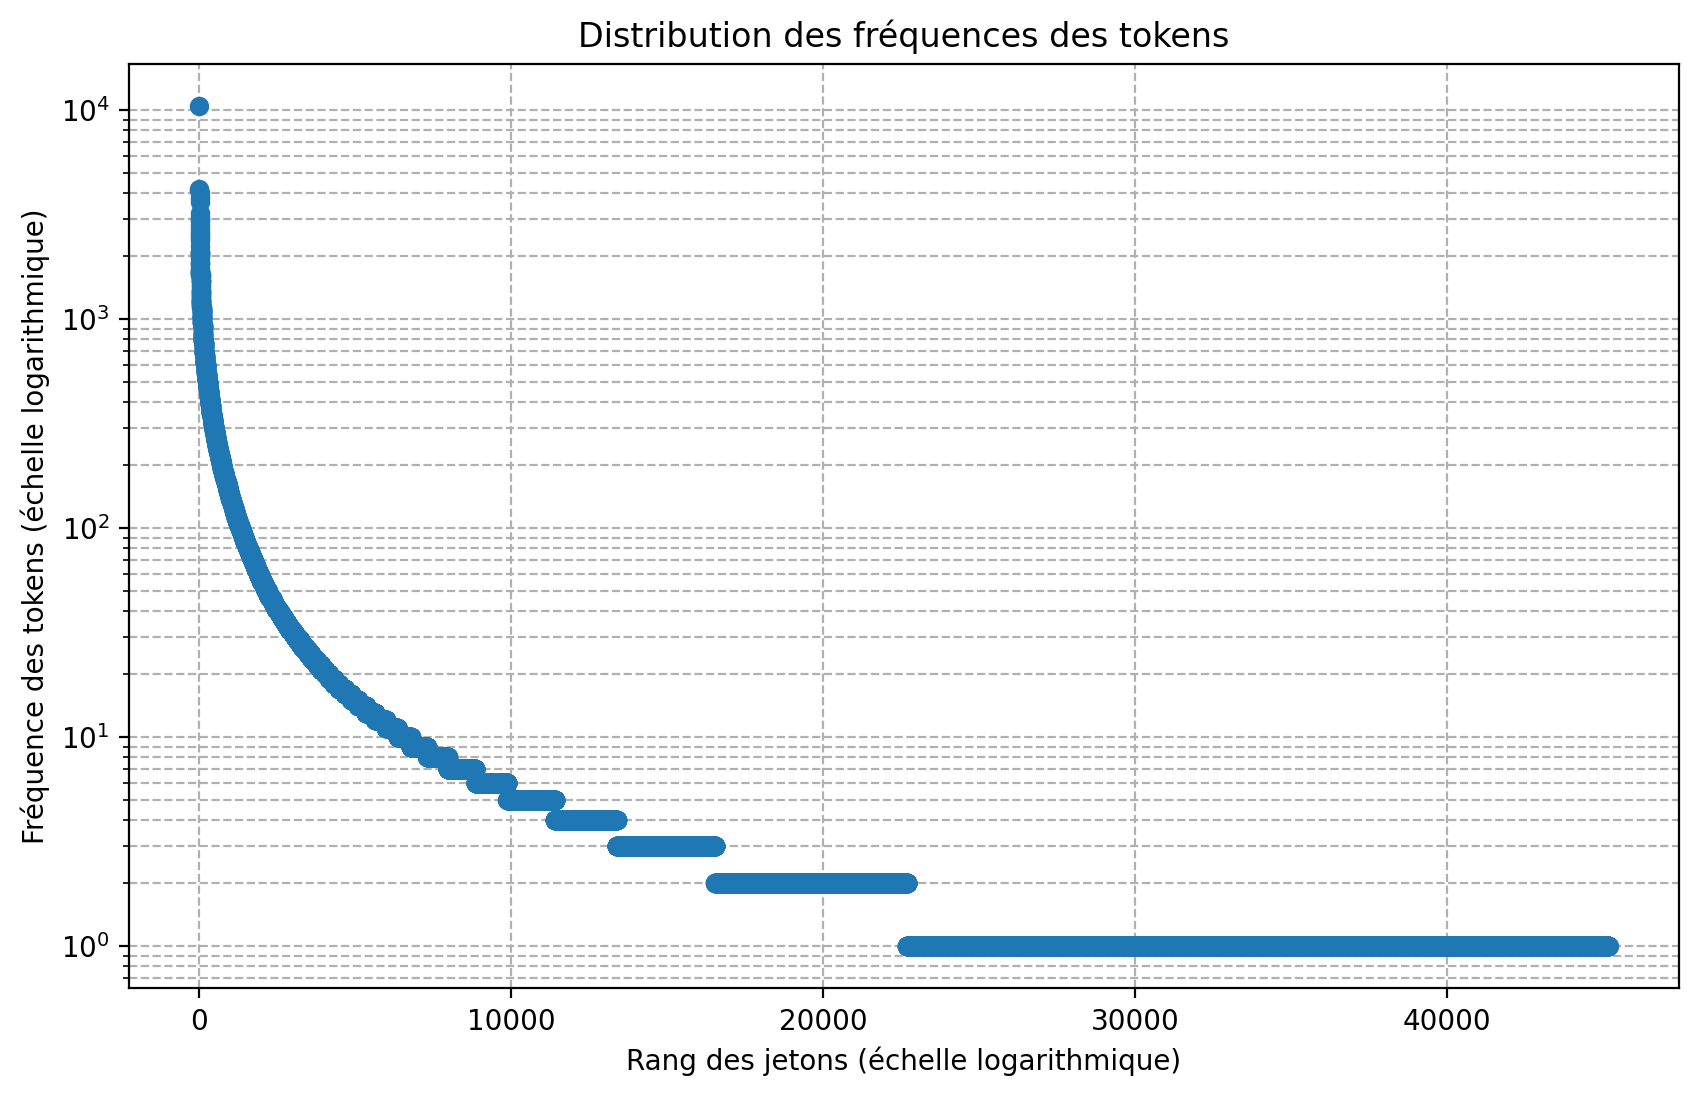

In [42]:
# Application de la fonction à vocab

dist_result = show_distribution(vocab)

##### 2.1.5 Vérification de la loi de Zipf (4 points)

Afin de vérifier la loi de Zipf, donnez une estimation de la valeur de la constante k de cette loi définie comme suit: 

$$ f \approx \frac{k}{r^\alpha} $$ 

où $ f $ est la fréquence d'un mot, $ r $ est le rang de ce mot dans la liste triée par fréquence décroissante, et $ k $ est une constante. Etant données les fluctuations sur les valeurs de fréquence, vous pouvez utiliser la librairie ['powerlaw'](https://pypi.org/project/powerlaw/) conçue pour analyser et ajuster des distributions de loi de puissance aux données et qui peut être utile dans l'estimation de $ \alpha $.

Affichez la constante $ k $ trouvée, les fréquences réelles des mots avec celles qui sont prédites par la loi de Zipf.

Calculating best minimal value for power law fit
Constante k : 12131.76


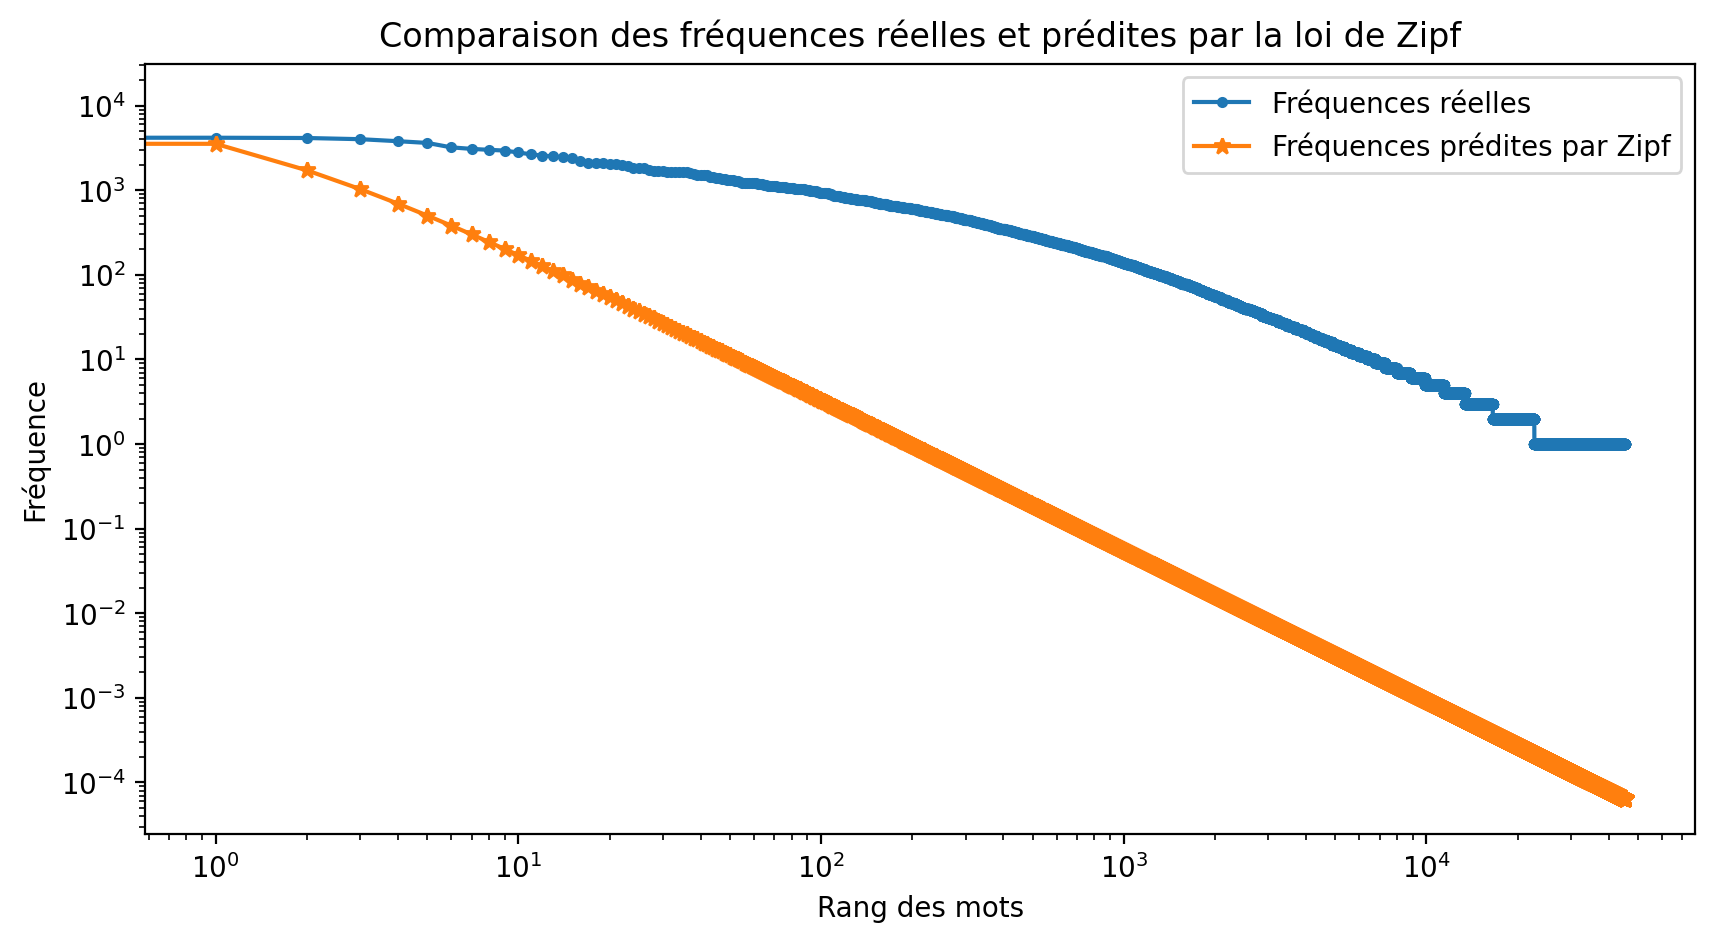

In [43]:
# Tri des fréquences des mots par ordre décroissant
frequencies = sorted(vocab.values(), reverse=True)

# Estimation du paramètre alpha de la loi de puissance
data = powerlaw.Fit(frequencies)
alpha = data.power_law.alpha

# Tableau des rangs et ajustement avec alpha
r = np.arange(1, len(frequencies) + 1) ** (-alpha)

# Calcul de la pente k avec une régression linéaire
slope = np.polyfit(r, frequencies, 1)[0]
print(f"Constante k : {slope:.2f}")

# Fréquences prédites par la loi de Zipf
predicted_freq = [slope / ((i+1)**alpha) for i in range(len(frequencies))]

# Affichage du graphe
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, label='Fréquences réelles', marker='.', linestyle='-')
plt.loglog(predicted_freq, label="Fréquences prédites par Zipf", marker="*", linestyle='-')
plt.xlabel("Rang des mots")
plt.ylabel('Fréquence')
plt.title('Comparaison des fréquences réelles et prédites par la loi de Zipf')
plt.legend()
plt.show()

#### 2.2  Création d’un modèle sac de mots (10 points)

##### 2.2.1 Répresentation de texte (5 points)

En utilisant sklearn et à partir de vos données pré-traitées ("_claims_preprocessed_", "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_"), représentez chaque affirmation (_claim_) et document avec le vocabulaire créé 'précédemment dans la variables "_claims_preprocessed_joined", "_titles_preprocessed_joined_", "_abstract_preprocessed_joined_" et "_texts_preprocessed_joined_". Cela veut dire que tout jeton qui n'est pas dans le vocabulaire doit être enlevé dans le document et l'affirmation. Faites cela pour les trois possibilités de représentation de document: "_title_", "_abstract_" et "_text_".

In [44]:
def filter_join(tokens_listes, vocab):
    return [' '.join(token for token in tokens if token in vocab) for tokens in tokens_listes]

# Application du filtrage et de la jointure pour chaque colonne
claims_preprocessed_joined = filter_join(df_claims['claims_preprocessed'], vocab)
titles_preprocessed_joined = filter_join(df_corpus['titles_preprocessed'], vocab)
abstracts_preprocessed_joined = filter_join(df_corpus['abstracts_preprocessed'], vocab)
texts_preprocessed_joined = filter_join(df_corpus['texts_preprocessed'], vocab)

In [45]:
# Fonction pour exclure les tokens qui ne sont pas dans le vocabulaire
def excluser_tokens(tokens, vocab):
    return [[token for token in tokens_list if token in vocab] for tokens_list in tokens]

# Application de la fonction
claims_preprocessed_filtered = excluser_tokens(df_claims['claims_preprocessed'], vocab) 
titles_preprocessed_filtered = excluser_tokens(df_corpus['titles_preprocessed'], vocab)
abstracts_preprocessed_filtered = excluser_tokens(df_corpus['abstracts_preprocessed'], vocab)
texts_preprocessed_filtered = excluser_tokens(df_corpus['texts_preprocessed'], vocab)

# Convertion des listes de tokens filtrés en chaînes de caractères avec la fonction join()
claims_preprocessed_joined = [' '.join(tokens) for tokens in claims_preprocessed_filtered]  # Liste d'affirmations prétraitées
titles_preprocessed_joined = [' '.join(tokens) for tokens in titles_preprocessed_filtered]  # Liste de titres prétraités
abstracts_preprocessed_joined = [' '.join(tokens) for tokens in abstracts_preprocessed_filtered]  # Liste d'abstracts prétraités
texts_preprocessed_joined = [' '.join(tokens) for tokens in texts_preprocessed_filtered]  # Liste de textes prétraités

##### 2.2.2 Pondération (4 points)

En utilisant un modèle sac de mots basé sur des unigrammes et des bigrammes, créez une représentation vectorielle de vos documents (titles, abstracts, texts) et de vos affirmations (claims) avec TF-IDF en utilisant le TfidfVectorizer de sklearn. 

In [46]:
# Combiner les corpus
combined_corpus = claims_preprocessed_joined + texts_preprocessed_joined

# Initialiser et entraîner le TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(combined_corpus)

# Application du TfidfVectorizer pour obtenir les représentations vectorielles TF-IDF
claims_tfidf = tfidf_vectorizer.transform(claims_preprocessed_joined) 
titles_tfidf = tfidf_vectorizer.transform(titles_preprocessed_joined) 
abstracts_tfidf = tfidf_vectorizer.transform(abstracts_preprocessed_joined) 
texts_tfidf = tfidf_vectorizer.transform(texts_preprocessed_joined) # 

##### 2.2.3 Affichage (1 point)

Affichez les dimensions (shape) de vos corpus (claims, text, title, abstract) après vectorisation

In [47]:
print("Claims TF-IDF shape:", claims_tfidf.shape)

Claims TF-IDF shape: (809, 473643)


Sortie attendue pour "_claims_"
```
(809, 473643)
```

In [48]:
print("Texts TF-IDF shape:", texts_tfidf.shape)

Texts TF-IDF shape: (5183, 473643)


Sortie attendue pour "_texts_"
```
(5183, 473643)
```

In [49]:
print("Titles TF-IDF shape:", titles_tfidf.shape)

Titles TF-IDF shape: (5183, 473643)


Sortie attendue pour "_titles_"
```
(5183, 473643)
```

In [50]:
print("Abstracts TF-IDF shape:", abstracts_tfidf.shape)

Abstracts TF-IDF shape: (5183, 473643)


Sortie attendue pour abstracts
```
(5183, 473643)

#### 2.3 Pertinence d'un document (20 points)

Maintenant que vous avez une représentation de vos affirmations "_claims_" et documents ("_texts_", "_titles_", "_abstracts_"), il faut être capable de déterminer quel document sera le plus pertinent pour une affirmation donnée.

##### 2.3.1 Implémentation de "_eval_similarity_" (3 points)

Implémentez la fonction "_eval_similarity_" pour évaluer la similarité cosinus entre la représentation de l'affirmation et celle de chaque document. La fonction prend une liste d'affirmations et une liste de documents et retourne une matrice où chaque ligne représente une affirmation et chaque colonne représente un document ("title", "abstract" ou "text") et les valeurs sont les similarités cosinus entre une affirmation et un document.

In [51]:
# Fonction pour évaluer la similarité cosinus entre la représentation de l'affirmation et celle de chaque document
def eval_similarity(claims_tfidf, documents_tfidf):
    
    similarity_matrix=cosine_similarity(claims_tfidf, documents_tfidf) 
    return similarity_matrix

##### 2.3.2 Implémentation de la fonction "_rank_texts_" (2 points)

Implémentez la fonction "_rank_texts_", qui, au moyen de la précédente (_eval_similarity_), retourne le top-N (N=1,3,5) des documents pertinents pour une affirmation donnée (N est un paramètre). Ces documents devront être ordonnés du plus pertinent au moins pertinent. Idéalement, le document à la position 1 sera celui qui contient la preuve (ou justification) de l'affirmation. Il faudra retourner non pas les indices des documents dans le dataframe mais plutôt leur identifiants au niveau de la colonne "_doc_id_".

In [52]:
def rank_texts(claims_tfidf, docs_tfidf, N=5):
    
    # Calcul de la matrice de similarité cosinus entre les affirmations et les documents
    similarity_matrix_claims_docs = cosine_similarity(claims_tfidf, docs_tfidf)

    # Initialisation de la liste des top N documents
    top_documents = []

    # Parcours de chaque affirmation
    for idx, similarities in enumerate(similarity_matrix_claims_docs):
        
        # Récupération des indices des N documents les plus similaires
        top_indices = np.argsort(similarities)[::-1][:N]
        
        # Récupération des identifiants des documents correspondants aux indices
        top_doc_ids = [str(df_corpus.iloc[i]['doc_id']) for i in top_indices]
        
        # Ajout à la liste finale des documents
        top_documents.append(top_doc_ids)

    return top_documents

In [53]:
def rank_texts(claims_tfidf, docs_tfidf, N=5):
    
    # Calcul de la matrice de similarité cosinus entre les affirmations et les documents
    similarity_matrix_claims_docs = cosine_similarity(claims_tfidf, docs_tfidf)
    
    top_documents = []  # Initialisation de la liste des top N documents
    
    # Pour chaque ligne dans la matrice de similarité (chaque affirmation)
    for idx, similarities in enumerate(similarity_matrix_claims_docs):
        # Récupération des indices des N documents les plus similaires
        top_indices = np.argsort(similarities)[::-1][:N]  # La méthode np.argsort() permet de trier les indices
        # Récupération des identifiants des documents correspondants aux indices
        top_doc_ids = [str(df_corpus.iloc[i]['doc_id']) for i in top_indices]  # Assurez-vous que les identifiants soient des chaînes
        # Ajout à la liste finale des documents
        top_documents.append(top_doc_ids)
    
    return top_documents

##### 2.3.3 Préparation des dataframes de réponses (1 point) 

Vous allez écrire la fonction "prepare_results_df" qui crée les dataframes qui vont contenir les résultats de la recherche de documents pertinents pour les affirmations.

La fonction "prepare_results_df" prend les arguments suivants:

- '_df_': le dataframe original nommé '_df_claims_' à partir duquel on crée les autres, 
- '_columns_to_drop_': les colonnes à supprimer 
- '_column_to_rename_': le nom de la colonne de référence dans le dataframe original qui sera renommée "gold standard passage"

et effectue les opérations suivantes:

1. Créer un nouveau dataframe à partir de "_df_claims_" en supprimant toutes les colonnes sauf "cited_doc_ids".
2. Renommer la colonne "cited_doc_ids" en "gold standard passage".
3. Ajouter les colonnes "top_1", "top_3", et "top_5" au dataframe, 
en les initialisant avec des chaînes de zéros séparés par des points-
virgules, correspondant respectivement à des configurations de 1, 3, et 
5 zéros pour toutes les lignes.

Vous utiliserez ensuite cette fonction pour créer les dataframes "results_titles_df", "results_abstracts_df" et "results_texts_df", qui seront destinés à contenir les résultats de recherche de documents pour "title", "abstract" et "text" respectivement.

In [54]:
def prepare_results_df(df, columns_to_drop, column_to_rename):
    
    # Création d'un nouveau df en supprimant les colonnes indiquées
    new_df = df.drop(columns=columns_to_drop)

    # Rename de la colonne spécifiée
    new_df = new_df.rename(columns={column_to_rename: "gold standard passage"})

    # Ajout des colonnes 'top_1', 'top_3', et 'top_5' initialisées avec des chaînes de zéros
    new_df["top_1"] = "0"
    new_df["top_3"] = ";".join(["0"] * 3)
    new_df["top_5"] = ";".join(["0"] * 5)  

    return new_df

# Test de la fonction
df = df_claims.copy()
results_titles_df = prepare_results_df(df, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')

print("Test de sortie sur le df_claims:")
results_titles_df.head(3)

Test de sortie sur le df_claims:


,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],0,0;0;0,0;0;0;0;0
1,2,[13734012],0,0;0;0,0;0;0;0;0
2,4,[22942787],0,0;0;0,0;0;0;0;0


> Sortie attendue pour chaque dataframe préparé
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>gold standard passage</th>
      <th>top_1</th>
      <th>top_3</th>
      <th>top_5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>[31715818]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>[13734012]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>[22942787]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
  </tbody>
</table>
</div>

##### 2.3.4 Implémentation de la fonction "_fill_results_" (2 points)

Vous devez maintenant implémenter la fonction "_fill_results_" qui remplit les dataframes préparés dans l'étape précédente en utilisant les resultats de recherche de document.
Cette fonction prend les arguments suivant: 
- "_results_" : matrice contenant les valeurs de similarite des affirmations et des documents
- "_results_texts_df_" : Dataframe contenant les affirmations ainsi que les colonnes "top_1", "top_3", "top_5" où doivent être mis les top-n documents les plus pertinents.

Les deux arguments contiennent le même nombre d'éléments et pour le même indice, font référence à la même affirmation.

In [55]:
def fill_results(results, results_texts_df):
    
    # Parcourir chaque ligne de résultat (chaque affirmation)
    for i, top_n_doc_ids in enumerate(results):
        
        # Conversion des identifiants de document en chaînes de caractères
        top_n_doc_ids_str = [str(doc_id) for doc_id in top_n_doc_ids]

        # Remplissage des colonnes 'top_1', 'top_3', et 'top_5' pour chaque affirmation
        results_texts_df.at[i, "top_1"] = top_n_doc_ids_str[0]  # Premier document le plus pertinent
        results_texts_df.at[i, "top_3"] = ";".join(top_n_doc_ids_str[:3])  # Les trois premiers documents
        results_texts_df.at[i, "top_5"] = ";".join(top_n_doc_ids_str[:5])  # Les cinq premiers documents

    return results_texts_df

##### 2.3.5 Exécution des fonctions "_rank_texts_" et fill_results(2 points)

Exécutez maintenant votre fonction "_rank_texts_" sur toutes les affirmations (claims) et toutes les représentations de documents (title, abstract, text) en mettant les résultats dans les variables "results_texts", "results_titles" et "results_abstracts". Ensuite appelez la fonction "_fill_results_" qui remplit les dataframes "_results_titles_df_", "_results_abstracts_df_", et "_results_texts_df_" contenant les résultats de recheche de documents.

In [56]:
# Préparation des DataFrames résultats avec appel de la fonction prepare_results_df
results_titles_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_abstracts_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_texts_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')

# Appel de la fonction rank_texts 
results_texts = rank_texts(claims_tfidf, texts_tfidf)
results_titles = rank_texts(claims_tfidf, titles_tfidf)
results_abstracts = rank_texts(claims_tfidf, abstracts_tfidf)

In [57]:
print("Appel de la fonction fill_results sur results_texts et results_texts_df")
fill_results(results_texts, results_texts_df)

Appel de la fonction fill_results sur results_texts et results_texts_df


,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],10608397,10608397;42421723;10607877,10608397;42421723;10607877;21257564;35008773
1,2,[13734012],13734012,13734012;17333231;13770184,13734012;17333231;13770184;42240424;3716075
2,4,[22942787],7165938,7165938;1387104;520579,7165938;1387104;520579;10958594;52188256
3,6,[2613775],23117378,23117378;2613775;21050357,23117378;2613775;21050357;20240998;35521287
4,9,[44265107],44265107,44265107;24700152;14647747,44265107;24700152;14647747;26105746;25182647
...,...,...,...,...,...
804,1403,"[33370, 38355793]",33370,33370;38355793;45764440,33370;38355793;45764440;40412980;7986878
805,1404,"[33370, 38355793]",38355793,38355793;33370;45764440,38355793;33370;45764440;40412980;7986878
806,1405,[10504681],20402596,20402596;10504681;38675228,20402596;10504681;38675228;5849439;14926162
807,1406,[2617858],2617858,2617858;4465762;4857085,2617858;4465762;4857085;10577574;13963620


In [58]:
print("Appel de la fonction fill_results sur results_titles et results_titles_df")
fill_results(results_titles, results_titles_df)

Appel de la fonction fill_results sur results_titles et results_titles_df


,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],10029970,10029970;42421723;4459491,10029970;42421723;4459491;25950264;31543713
1,2,[13734012],4828631,4828631;32481310;103007,4828631;32481310;103007;17415081;7020505
2,4,[22942787],10958594,10958594;12074066;24980622,10958594;12074066;24980622;39903312;42731834
3,6,[2613775],2613775,2613775;23117378;21050357,2613775;23117378;21050357;20287253;39381118
4,9,[44265107],44265107,44265107;24700152;14647747,44265107;24700152;14647747;26105746;29366489
...,...,...,...,...,...
804,1403,"[33370, 38355793]",6944800,6944800;33370;24282306,6944800;33370;24282306;13329980;38355793
805,1404,"[33370, 38355793]",32852283,32852283;6944800;33370,32852283;6944800;33370;24282306;13329980
806,1405,[10504681],10504681,10504681;5849439;26378103,10504681;5849439;26378103;435529;7681810
807,1406,[2617858],2617858,2617858;4857085;11419230,2617858;4857085;11419230;27768226;13283919


In [59]:
print("Appel de la fonction fill_results sur results_abstracts et results_abstracts_df")
fill_results(results_abstracts, results_abstracts_df)

Appel de la fonction fill_results sur results_abstracts et results_abstracts_df


,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],10608397,10608397;10607877;21257564,10608397;10607877;21257564;994800;14827874
1,2,[13734012],13734012,13734012;17333231;13770184,13734012;17333231;13770184;42240424;3716075
2,4,[22942787],7165938,7165938;1387104;52188256,7165938;1387104;52188256;520579;43334921
3,6,[2613775],23117378,23117378;21050357;2613775,23117378;21050357;2613775;20240998;35521287
4,9,[44265107],44265107,44265107;24700152;14647747,44265107;24700152;14647747;25182647;32787042
...,...,...,...,...,...
804,1403,"[33370, 38355793]",33370,33370;38355793;7986878,33370;38355793;7986878;40412980;45764440
805,1404,"[33370, 38355793]",38355793,38355793;33370;7986878,38355793;33370;7986878;40412980;45764440
806,1405,[10504681],20402596,20402596;38675228;10504681,20402596;38675228;10504681;5849439;19950357
807,1406,[2617858],2617858,2617858;4465762;4857085,2617858;4465762;4857085;13963620;10577574


##### 2.3.6 Enregistrement des dataframes 

On enregistre les dataframes dans des fichiers .csv.

In [60]:
results_texts_df.to_csv('results_texts.csv',index=False, sep='\t')
results_titles_df.to_csv('results_titles_df.csv',index=False, sep='\t')
results_abstracts_df.to_csv('results_abstracts_df.csv',index=False, sep='\t')

##### 2.3.7 Implémentation de la fonction "_show_top_n_passages_" (3 points)

Vous devez maintenant implémenter une fonction "_show_top_n_passages_" qui affiche le top-n ainsi que le texte (document) attendu pour une affirmation donnée. Ici on considère que document est representé par "_text_" donc la fusion du titre ("_title_") et du résumé ("_abstract_")

In [61]:
def show_top_n_passages(claim_id, N):
    
    # Verification de l'existence de l'ID de l'affirmation dans df_claims
    try:
        claim_index = df_claims.index[df_claims['id'] == claim_id][0]
    except IndexError:
        print(f"Aucun ID d'affirmation trouvé pour {claim_id}.")
        return
    
    top_n_doc_ids = results_texts_df.at[claim_index, f'top_{N}'].split(';')
    
    print(f"Affichage des top-{N} documents pour l'affirmation ID {claim_id} :")
    
    for rank, doc_id in enumerate(top_n_doc_ids, start=1):
        print(f" - Rang {rank}: Document ID {doc_id}")

##### 2.3.8 Affichage (1 point)

Appliquez cette fonction sur l'affirmation ayant pour identifiant 211 et affichez le top-5 des documents les plus pertinents retrouvés.

In [62]:
show_top_n_passages(211, 5)

Affichage des top-5 documents pour l'affirmation ID 211 :
 - Rang 1: Document ID 14019636
 - Rang 2: Document ID 44737533
 - Rang 3: Document ID 6290112
 - Rang 4: Document ID 20261352
 - Rang 5: Document ID 5137019


##### 2.3.9 Évaluation (3 points)

Vous devez maintenant implémenter la fonction "_evaluate_" qui, à partir des colonnes *Gold standard passage* et de vos top-N respectifs, calcule la précision top-N (N=1,3,5) sur l’ensemble de données en paramètre et l’affiche. 

Cette précision connue sous le nom "precision at k (precision@k)" se calcule de la manière suivante:


$$
\text{precision@k} = \frac{\text{nombre d'éléments corrects}}{\text{nombre total d'éléments k retrouvés}}
$$


Veillez à ce que la fonction soit générique. 

In [63]:
def evaluate_precision(results_df, gold_col='gold standard passage', top_n_cols=None):
    
    # Définition des noms de colonnes par défaut si non fournis
    if top_n_cols is None:
        top_n_cols = ['top_1', 'top_3', 'top_5']

    # Initialisation des compteurs de précision
    precision_counts = {'@1': 0, '@3': 0, '@5': 0}

    # Calcul du nombre total de lignes (affirmations) dans le dataframe
    total_count = len(results_df)

    # Parcours de chaque ligne du dataframe
    for _, row in results_df.iterrows():
        
        # Conversion de la colonne de référence en un ensemble pour une comparaison rapide
        gold_passages = set(map(str, row[gold_col]))

        # Obtention des documents top-N sous forme d'ensembles
        top_1_docs = set(row[top_n_cols[0]].split(';'))
        top_3_docs = set(row[top_n_cols[1]].split(';'))
        top_5_docs = set(row[top_n_cols[2]].split(';'))

        # Comptage du nombre de correspondances entre les passages de référence et les documents top-N
        precision_counts['@1'] += len(gold_passages.intersection(top_1_docs))
        precision_counts['@3'] += len(gold_passages.intersection(top_3_docs))
        precision_counts['@5'] += len(gold_passages.intersection(top_5_docs))

    # Calcul de la précision pour chaque top-N
    precision_at_1 = precision_counts['@1'] / total_count
    precision_at_3 = precision_counts['@3'] / (3 * total_count)
    precision_at_5 = precision_counts['@5'] / (5 * total_count)

    # Affichage des résultats
    print(f"Précision @1: {precision_at_1:.4f}")
    print(f"Précision @3: {precision_at_3:.4f}")
    print(f"Précision @5: {precision_at_5:.4f}")

    return precision_at_1, precision_at_3, precision_at_5

##### 2.3.10 Affichage (1 point)

Appliquez cette fonction pour calculer la précision des documents retrouvés en utilisant les titres ("_title_"), les résumés ("_abstract_") et la fusion des deux ("_text_").

In [64]:
# Calcul de la précision à partir des résultats des titres
print("Précision pour les titles :")
precision_titles = evaluate_precision(results_titles_df)

# Calcul de la précision à partir des résultats des résumés
print("\nPrécision pour les abstracts :")
precision_abstracts = evaluate_precision(results_abstracts_df)

# Calcul de la précision à partir des résultats des textes (fusion de titre et résumé)
print("\nPrécision pour les texts (title + abstract) :")
precision_texts = evaluate_precision(results_texts_df)

Précision pour les titles :
Précision @1: 0.3226
Précision @3: 0.1636
Précision @5: 0.1117

Précision pour les abstracts :
Précision @1: 0.4660
Précision @3: 0.2167
Précision @5: 0.1439

Précision pour les texts (title + abstract) :
Précision @1: 0.4870
Précision @3: 0.2254
Précision @5: 0.1520


##### 2.3.11 Graphique (2 points)

Tracez un graphique des valeurs de précisions des documents retrouvés ("__title__", "__abstract__", "__text__") pour différents N (1,3,5).

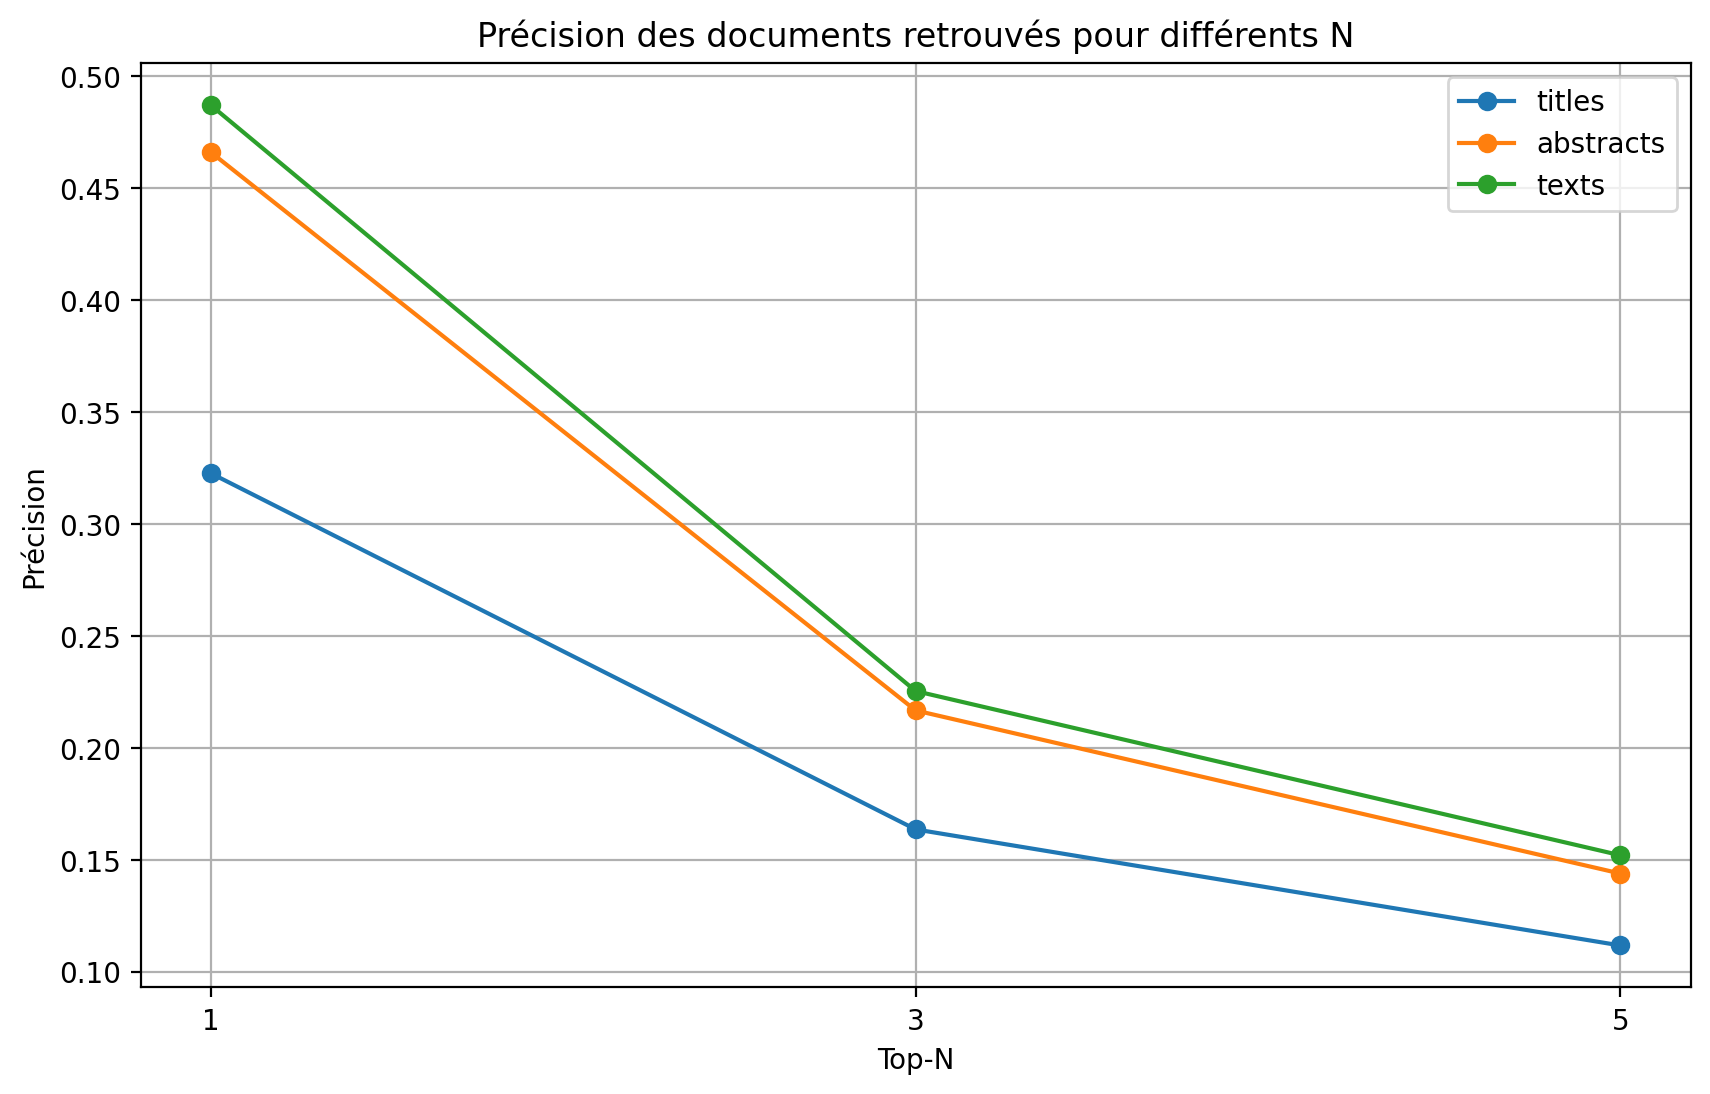

In [65]:
# Définition des types de documents et des valeurs de N
document_types = ['titles', 'abstracts', 'texts']
N_values = [1, 3, 5]

# Dictionnaire contenant les précisions pour chaque type de document
precisions = {
    'titles': precision_titles,
    'abstracts': precision_abstracts,
    'texts': precision_texts
}

# Création de la figure
fig, ax = plt.subplots(figsize=(10, 6))

# Tracé des courbes de précision pour chaque type de document
for doc_type in document_types:
    ax.plot(N_values, precisions[doc_type], marker='o', label=doc_type)

# Ajout des étiquettes et de la légende
ax.set_title('Précision des documents retrouvés pour différents N')
ax.set_xlabel('Top-N')
ax.set_ylabel('Précision')
ax.set_xticks(N_values)
ax.legend()
ax.grid(True)

# Affichage du graphique
plt.show()

### 3 Amélioration avec BM25 (20 points)

BM25 (Best Matching 25) est un algorithme de recherche utilisé pour évaluer la pertinence des documents par rapport à une requête. Basé sur le modèle de récupération d'informations probabilistes, BM25 calcule un score de pertinence en tenant compte de la fréquence des termes de la requête dans chaque document et dans le corpus global mais aussi de la longueur des documents. 

BM25 est pertinent pour la recherche d'information car il offre un bon équilibre entre précision et rappel, il gère efficacement de grandes collections de documents et permet des ajustements pour différents types de corpus. Il est largement utilisé dans les moteurs de recherche et les systèmes de recommandation.

Dans cette partie on vous demande de la tester au moyen de la librairie rank_bm25 pour cette tâche de recherche de texte qui justifie ou contredit une affirmation donnée. Vous allez utiliser le corpus et les affirmations et procéder comme indiqué dans la suite.

##### 3.1 Initialisation du modèle BM25 (3 points)
Réutilisez les variables "claims_preprocessed_joined", "texts_preprocessed_joined", "titles_preprocessed_joined" et "abstract_preprocessed_joined" définies à la question `2.2.1` pour initialiser les modèles BM25 pour les documents ("__titles__", "__abstracts__" et "__text__"). Il faudra transformer chaque séquence (dont les jetons étaient joints pour former une seule chaîne) en une liste de jetons. Vous utiliserez la classe "_BM250kapi_" à ce niveau. 

In [66]:
# Split des elements en liste de mots et stockage
claims_preprocessed = [claim.split() for claim in claims_preprocessed_joined]
titles_preprocessed = [title.split() for title in titles_preprocessed_joined]
abstracts_preprocessed = [abstracts.split() for abstracts in abstracts_preprocessed_joined]
texts_preprocessed = [text.split() for text in texts_preprocessed_joined]

# Initialisation des modèles BM25Okapi pour les titres, abstracts et textes.
bm25_titles = BM25Okapi(titles_preprocessed)
bm25_abstracts = BM25Okapi(abstracts_preprocessed)
bm25_texts = BM25Okapi(texts_preprocessed)

##### 3.2 Utilisation du modèle BM25 (5 points)

Retrouvez les identifiants des documents pour les cinq meilleures correspondances de "_title_", de "_abstract_" et de "_text_" en utilisant le score BM25 pour chaque affirmation (claim) traitée, et mettez à jour les résultats avec les identifiants de documents correspondants.

In [67]:
# Initialisation des listes pour stocker les résultats des scores BM25
results_titles_BM25 = []
results_abstracts_BM25 = []
results_texts_BM25 = []

doc_ids = df_corpus['doc_id'].tolist()

for claim in claims_preprocessed:

    # Calcul des scores BM25 pour titles, abstracts et texts
    title_scores = bm25_titles.get_scores(claim)
    abstract_scores = bm25_abstracts.get_scores(claim)
    text_scores = bm25_texts.get_scores(claim)

    # Sélection des indices des 5 meilleurs scores pour chaque catégorie
    top_titles = sorted(range(len(title_scores)), key=lambda k: title_scores[k], reverse=True)[:5]
    top_abstracts = sorted(range(len(abstract_scores)), key=lambda k: abstract_scores[k], reverse=True)[:5]
    top_texts = sorted(range(len(text_scores)), key=lambda k: text_scores[k], reverse=True)[:5]

    # Ajout des IDs de documents correspondants aux listes de résultats
    results_titles_BM25.append([doc_ids[idx] for idx in top_titles])
    results_abstracts_BM25.append([doc_ids[idx] for idx in top_abstracts])
    results_texts_BM25.append([doc_ids[idx] for idx in top_texts])
    
# Affichage des résultats pour les 5 premiers claims
print("Identifiants des documents pour les cinq meilleures correspondances pour chaque affirmation :\n")
for index in range(min(5, len(results_titles_BM25))):  # Limiter l'affichage aux 5 premiers résultats
    titles = results_titles_BM25[index]
    abstracts = results_abstracts_BM25[index]
    texts = results_texts_BM25[index]
    print(f"Claim {index + 1}:")
    print(f"  Titles    : {titles}")
    print(f"  Abstracts : {abstracts}")
    print(f"  Texts     : {texts}\n")


Identifiants des documents pour les cinq meilleures correspondances pour chaque affirmation :

Claim 1:
  Titles    : [16532419, 25602549, 42421723, 14831629, 34935825]
  Abstracts : [26071782, 21257564, 825728, 28138927, 26731863]
  Texts     : [26071782, 21257564, 18953920, 26731863, 825728]

Claim 2:
  Titles    : [32481310, 4828631, 103007, 1583134, 3870062]
  Abstracts : [13734012, 18617259, 42240424, 17333231, 21616324]
  Texts     : [13734012, 18617259, 4828631, 42240424, 17333231]

Claim 3:
  Titles    : [24980622, 10958594, 39903312, 31616203, 12074066]
  Abstracts : [1387104, 24980622, 10958594, 5641851, 13030852]
  Texts     : [10958594, 24980622, 1387104, 5641851, 13030852]

Claim 4:
  Titles    : [2613775, 23117378, 21050357, 7711685, 39381118]
  Abstracts : [23117378, 2613775, 20240998, 35521287, 21050357]
  Texts     : [23117378, 2613775, 35521287, 20240998, 21050357]

Claim 5:
  Titles    : [44265107, 24700152, 9056874, 8190282, 14647747]
  Abstracts : [44265107, 251826

##### 3.3 Affichage des performances (4 points)

Affichez les résultats des performances BM25 pour les configurations Top1, Top3 et Top5 avec "_title_", "_asbtract_" et "_text_".

In [68]:
results_titles_BM25_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_abstracts_BM25_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')
results_texts_BM25_df = prepare_results_df(df_claims, ['claim', 'evidence', 'claim_length', 'num_cited_doc', 'claims_preprocessed'], 'cited_doc_ids')

results_titles_BM25_df = fill_results(results_titles_BM25, results_titles_BM25_df)
results_abstracts_BM25_df = fill_results(results_abstracts_BM25, results_abstracts_BM25_df)
results_texts_BM25_df = fill_results(results_texts_BM25, results_texts_BM25_df)

In [69]:
# Calcul des précisions
precisions_titles_BM25 = evaluate_precision(results_titles_BM25_df)
precisions_abstracts_BM25 = evaluate_precision(results_abstracts_BM25_df)
precisions_texts_BM25 = evaluate_precision(results_texts_BM25_df)

# Tableau des résultats
table_data = [
    ["Titles", *precisions_titles_BM25],
    ["Abstracts", *precisions_abstracts_BM25], 
    ["Texts", *precisions_texts_BM25]
]

# Affichage 
print(tabulate(table_data, headers=['Precision par BM25', 'Précision@1', 'Précision@3', 'Précision@5'], tablefmt='grid'))

Précision @1: 0.3239
Précision @3: 0.1475
Précision @5: 0.0994
Précision @1: 0.5538
Précision @3: 0.2344
Précision @5: 0.1567
Précision @1: 0.5674
Précision @3: 0.2394
Précision @5: 0.1582
+----------------------+---------------+---------------+---------------+
| Precision par BM25   |   Précision@1 |   Précision@3 |   Précision@5 |
+======================+===============+===============+===============+
| Titles               |      0.323857 |      0.147507 |      0.099382 |
+----------------------+---------------+---------------+---------------+
| Abstracts            |      0.55377  |      0.234446 |      0.156737 |
+----------------------+---------------+---------------+---------------+
| Texts                |      0.567367 |      0.23939  |      0.15822  |
+----------------------+---------------+---------------+---------------+


##### 3.4 Graphique (4 points)

Dans un même graphique, affichez les performances pour les deux modèles (TF-IDF et BM25) dans la recherche des documents (text, title et abstract) pour les affirmations.

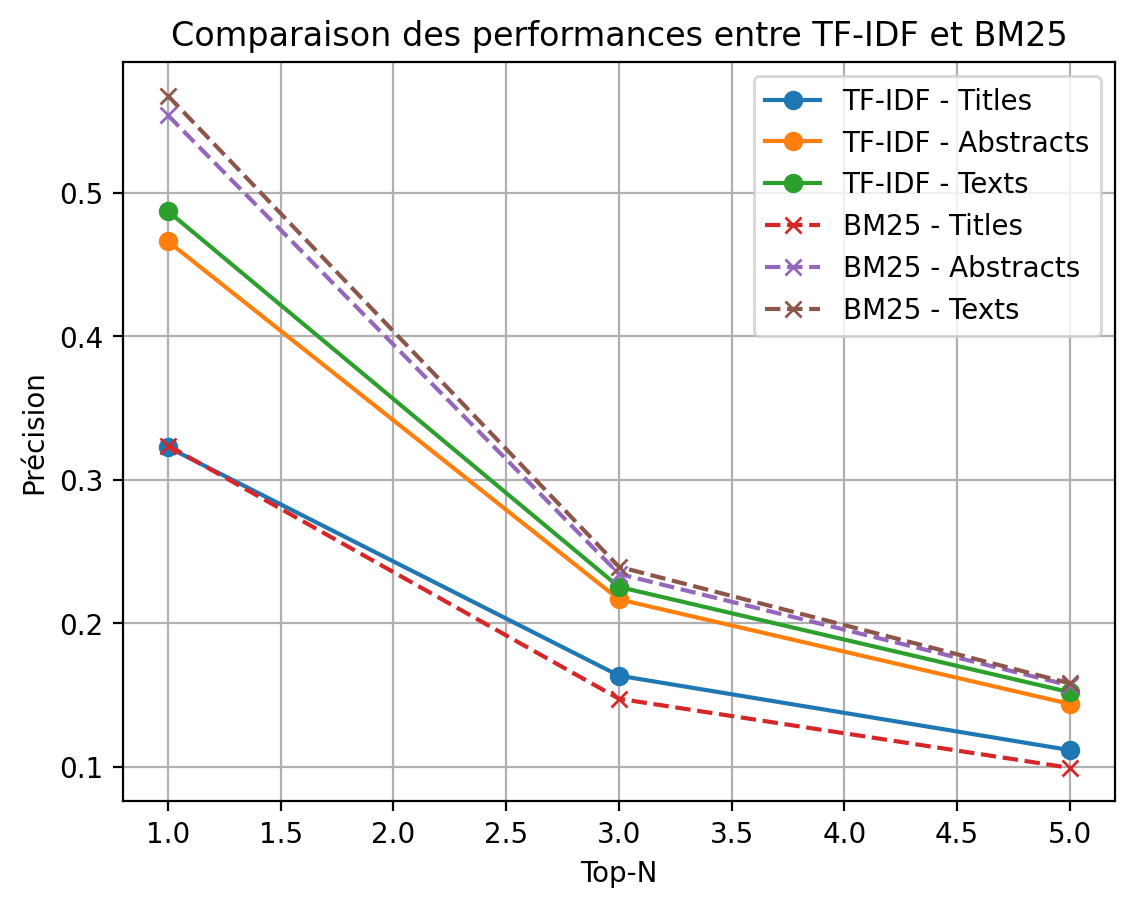

In [70]:
# Définition des valeurs de N
N_values = [1, 3, 5]

# Création de la figure
plt.figure()

# Courbes de précision pour TF-IDF
plt.plot(N_values, precision_titles, marker='o', label='TF-IDF - Titles')
plt.plot(N_values, precision_abstracts, marker='o', label='TF-IDF - Abstracts')
plt.plot(N_values, precision_texts, marker='o', label='TF-IDF - Texts')

# Courbes de précision pour BM25
plt.plot(N_values, precisions_titles_BM25, marker='x', label='BM25 - Titles', linestyle='--')
plt.plot(N_values, precisions_abstracts_BM25, marker='x', label='BM25 - Abstracts', linestyle='--')
plt.plot(N_values, precisions_texts_BM25, marker='x', label='BM25 - Texts', linestyle='--')

# Personnalisation du graphique
plt.xlabel('Top-N')
plt.ylabel('Précision')
plt.title('Comparaison des performances entre TF-IDF et BM25')
plt.legend()
plt.grid()

# Affichage du graphique
plt.show()

##### 3.5 Observation (4 points)

Par rapport à vos résultats avec TF-IDF, observez-vous une amélioration ou une détérioration des performances, qu'est ce qui explique cela ? (Donnez au moins trois justifications)

<font color='red'>

#### On observe une amélioration des performances pour BM25 comparé à TF-IDF pour plusieurs raisons :
   1. BM25 permet des ajustements paramétriques qui optimisent les performances selon les caractéristiques des documents, alors que TF-IDF est plus rigide.
   2. La fonction de pondération plus complexe de BM25, qui prend en compte la saturation des termes explique en partie sa supériorité.
   3. BM25 corrige mieux l'impact des documents longs ou courts, tandis que TF-IDF ne tient pas compte de la longueur du document. Cela désavantage TF-IDF lorsqu'il s'agit de longs textes.

</font>


## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
